Load MNIST data.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

A fuzzy classifier is trained on the original feature space.

Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0953 - categorical_accuracy: 0.8649 - val_loss: 0.0575 - val_categorical_accuracy: 0.9078
Epoch 2/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.0556 - categorical_accuracy: 0.9091 - val_loss: 0.0507 - val_categorical_accuracy: 0.9148
Epoch 3/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0506 - categorical_accuracy: 0.9166 - val_loss: 0.0477 - val_categorical_accuracy: 0.9207
Epoch 4/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0484 - categorical_accuracy: 0.9201 - val_loss: 0.0464 - val_categorical_accuracy: 0.9236
Epoch 5/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.0468 - categorical_accuracy: 0.9228 - val_loss: 0.0452 - val_categorical_accuracy: 0.9258
Epoch 6/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.0458 - categor

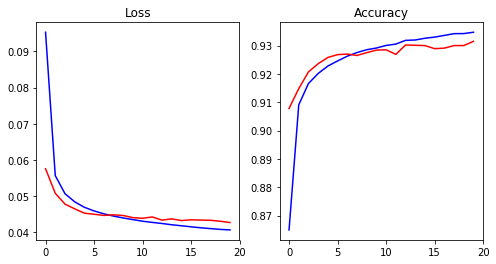

In [2]:
import keras
import keras.layers as layers
import keras.models as models
import keras.regularizers as regularizers
import keras.backend as K
from model import LogGaussMF


def train_baseline():
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


baseline_model = train_baseline()

When the classifier is trained in the original feature space, mu and beta can be plotted as images in the original feature space. This will not work when convolutional layers are being used. Additionally, the images of mu and beta don't provide a lot of information.

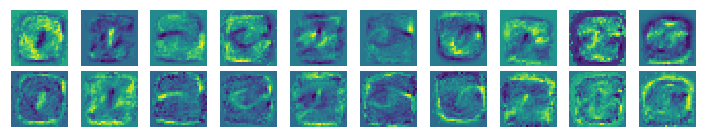

In [3]:
mu, beta = baseline_model.layers[-3].get_weights()

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28,28))
    axes[1][i].imshow(beta[i,:].reshape(28,28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

One convoltutional layer is added to the model to improve is classification power.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 71us/step - loss: 0.1292 - categorical_accuracy: 0.8325 - val_loss: 0.0598 - val_categorical_accuracy: 0.9050
Epoch 2/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0547 - categorical_accuracy: 0.9076 - val_loss: 0.0471 - val_categorical_accuracy: 0.9207
Epoch 3/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0464 - categorical_accuracy: 0.9218 - val_loss: 0.0422 - val_categorical_accuracy: 0.9289
Epoch 4/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0414 - categorical_accuracy: 0.9317 - val_loss: 0.0388 - val_categorical_accuracy: 0.9381
Epoch 5/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.0376 - categorical_accuracy: 0.9383 - val_loss: 0.0351 - val_categorical_accuracy: 0.9434
Epoch 6/20
60000/60000 [==============================] - 4s 58us/step - loss: 0.0342 - categor

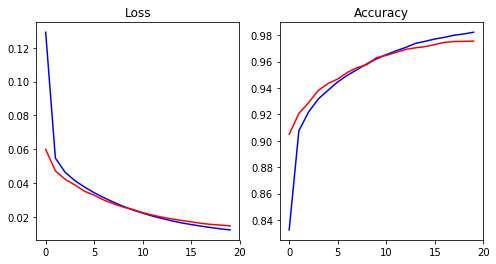

In [4]:
def train_conv1():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, padding="same"),
        layers.Activation("relu"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0001),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


conv1_model = train_conv1()

The most important pixels for each class of image are determined using the following process. Guided backprop is run on each training sample of the same class, with the target neuron being that images class. The resulting images are then rectified and a single representative image is created by taking the mean of all the images. This is repeated for all 10 classes.

The resulting images are scaled so that the values range from 0 to 1 and fed back into the classifier to ensure that it gives the correct prediction. Sometimes the mispredicts the image, but this is dealt with in the next cell.

0
8
2
3
4
8
6
7
8
9


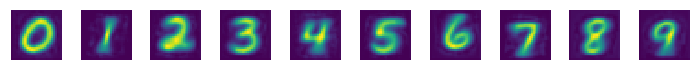

In [5]:
import innvestigate
from keras.models import Model


labels = np.argmax(train_y, axis=1)


model_wo_softmax = Model(conv1_model.inputs, [conv1_model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

    
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i]
    analysis = analyzer.analyze(images, i)
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)

    axes[i].imshow(analysis)
    print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))))
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

A threshold between 0 and 1 is added, and all pixels below the threshold are set to zero. This seems to solved the problem of the model incorrectly classifying the representative images.

0
1
2
3
4
5
6
7
8
9


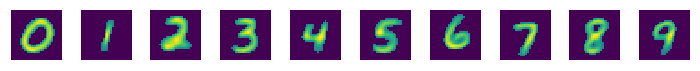

In [6]:
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i]
    analysis = analyzer.analyze(images, i)
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)
    
    # remove any values below abritrary threshold
    # improves the likelihood that image is classified correctly
    analysis *= (analysis > 0.4)

    axes[i].imshow(analysis)
    print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))))
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Changing the index of the neuron analyzed does not seem to affect the image at all, nor effect the classification result.

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 
5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 
7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 
8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 
9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 


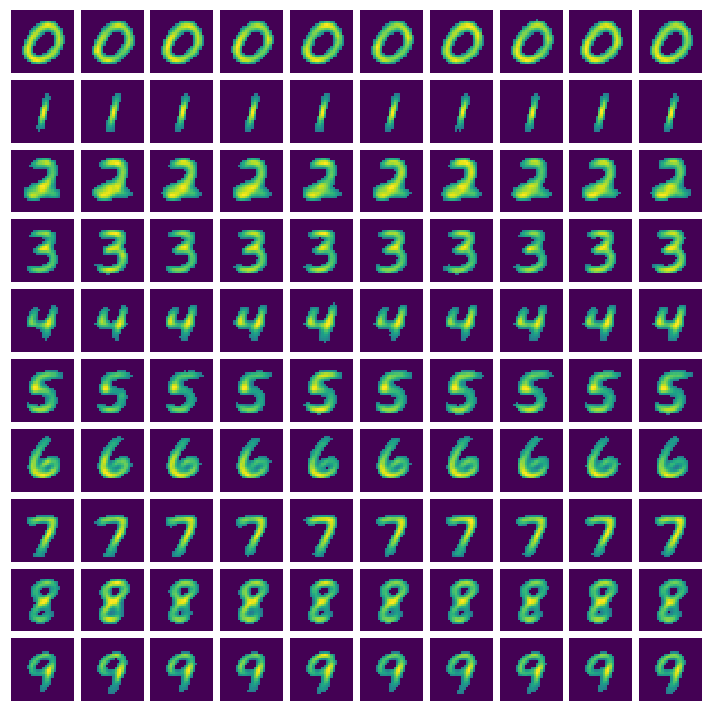

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        images = train_x[labels == i]
        analysis = analyzer.analyze(images, j)

        # rectify guided backprop results and get mean image
        analysis = np.maximum(analysis, 0.)
        analysis = np.mean(analysis, axis=0)

        # normalize between 0 and 1
        analysis -= np.min(analysis) 
        analysis /= np.max(analysis)

        # remove any values below abritrary threshold
        # improves the likelihood that image is classified correctly
        analysis *= (analysis > 0.4)

        axes[i][j].imshow(analysis)
        print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))), end=", ")
    print()
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

A larger convolutional model is trained.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.1083 - categorical_accuracy: 0.8328 - val_loss: 0.0488 - val_categorical_accuracy: 0.9200
Epoch 2/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0414 - categorical_accuracy: 0.9308 - val_loss: 0.0306 - val_categorical_accuracy: 0.9491
Epoch 3/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0262 - categorical_accuracy: 0.9559 - val_loss: 0.0216 - val_categorical_accuracy: 0.9657
Epoch 4/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0191 - categorical_accuracy: 0.9688 - val_loss: 0.0156 - val_categorical_accuracy: 0.9732
Epoch 5/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0156 - categorical_accuracy: 0.9742 - val_loss: 0.0136 - val_categorical_accuracy: 0.9765
Epoch 6/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0135 - categor

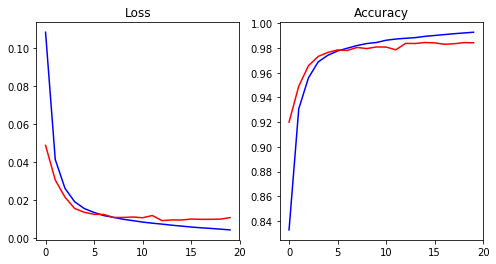

In [8]:
def train_conv2():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, padding="same"),
        layers.Activation("relu"),
        layers.Conv2D(32, 3, strides=2, padding="same"),
        layers.Activation("relu"),
        layers.Conv2D(64, 3, strides=2, padding="same"),
        layers.Activation("relu"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0001),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=128,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


conv2_model = train_conv2()

The images are not as clear as the model with the single convolutional layer, but still can be clearly made out. The threshold value had to be changed to 0.3 for the network to correctly classify the representatives.

0
1
2
3
4
5
6
7
8
9


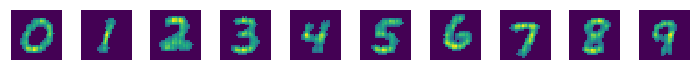

In [9]:
model_wo_softmax = Model(conv2_model.inputs, [conv2_model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i]
    analysis = analyzer.analyze(images, i)
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)
    
    # remove any values below abritrary threshold
    # improves the likelihood that image is classified correctly
    analysis *= (analysis > 0.3)

    axes[i].imshow(analysis)
    print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))))
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Again, changing out the neuron index has little to no effect on the image generated. I am not sure why this is case and it something that should be investigated.

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 
5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 
7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 
8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 
9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 


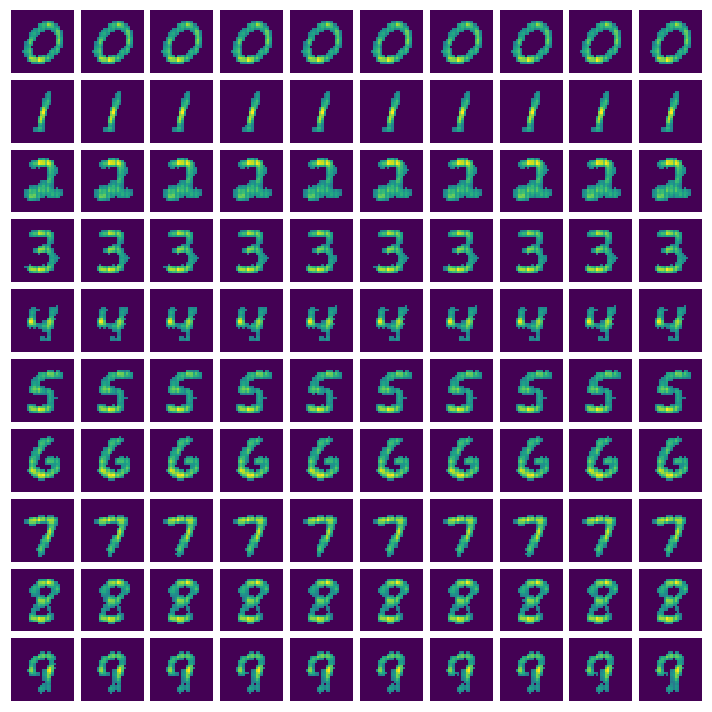

In [10]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        images = train_x[labels == i]
        analysis = analyzer.analyze(images, j)

        # rectify guided backprop results and get mean image
        analysis = np.maximum(analysis, 0.)
        analysis = np.mean(analysis, axis=0)

        # normalize between 0 and 1
        analysis -= np.min(analysis) 
        analysis /= np.max(analysis)

        # remove any values below abritrary threshold
        # improves the likelihood that image is classified correctly
        analysis *= (analysis > 0.4)

        axes[i][j].imshow(analysis)
        print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))), end=", ")
    print()
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The resnet20 model is loaded for analysis. 

**The cell after this cell will fail the first time the notebook is run. This cell will have to run again for the next cell to work correctly.**

In [14]:
from keras.models import load_model

# this has to be run twice to avoid an error with layer names
resnet20 = load_model(
    "saved_models/mnist_ResNet20v2_model.114.h5",
    custom_objects={
        "LogGaussMF": lambda **x: LogGaussMF(rules=10, **x)})

model_wo_softmax = Model(resnet20.inputs, [resnet20.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)

The images are fuzzier yet and the threshold value had to be changed to 0.38 in order for the model to make the correct predictions about the representatives. The results here imply that deeper, more complicated models cannot not be reversed as successfully as shallower models, and there is a trade-off between performance and interpretibility.

Additionally only 1000 samples from each class are used to create the representatives, in order to reduce memory usage. This may have effected their appearance.

0
1
2
3
4
5
6
7
8
9


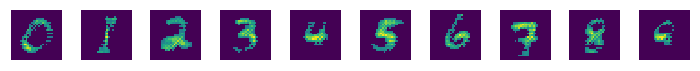

In [15]:
fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i][:1000].reshape(-1, 28, 28, 1)
    analysis = analyzer.analyze(images, i)
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)
    
    # remove any values below abritrary threshold
    # improves the likelihood that image is classified correctly
    analysis *= (analysis > 0.38)

    axes[i].imshow(analysis.squeeze())
    print(np.argmax(conv1_model.predict(analysis.reshape(1,28,28))))
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The second convolutional model will be used for the analysis in the next part of this notebook for the sake of convenience. The representative images are generated and stored for later used.

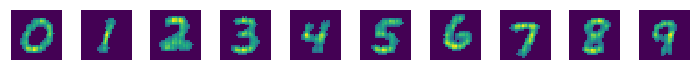

In [16]:
model_wo_softmax = Model(conv2_model.inputs, [conv2_model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True)


representatives = np.empty((10,28,28))

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i]
    analysis = analyzer.analyze(images, i)
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)
    
    # remove any values below abritrary threshold
    # improves the likelihood that image is classified correctly
    analysis *= (analysis > 0.3)

    axes[i].imshow(analysis)
    representatives[i] = analysis
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The 10x10 grid below shows each of the representative images multiplied with another one of the 10 representatives. This is a heuristic way to determine how similar any two digits representatives are to each other.

Some interesting things can be seen, like that the digit eight shared important pixels with nearly every other digit.

65.6, 13.4, 41.5, 36.4, 25.8, 46.2, 43.2, 27.1, 43.9, 30.2, 
13.4, 26.1, 21.9, 20.1,  9.2, 18.4, 15.2, 13.7, 23.1, 13.4, 
41.5, 21.9, 70.1, 45.1, 27.8, 40.1, 45.8, 31.3, 50.3, 33.8, 
36.4, 20.1, 45.1, 56.1, 21.8, 47.6, 32.2, 25.7, 47.8, 29.1, 
25.8,  9.2, 27.8, 21.8, 40.0, 29.3, 30.1, 30.5, 32.2, 37.5, 
46.2, 18.4, 40.1, 47.6, 29.3, 59.7, 39.3, 31.7, 53.6, 36.5, 
43.2, 15.2, 45.8, 32.2, 30.1, 39.3, 65.1, 27.9, 39.9, 33.8, 
27.1, 13.7, 31.3, 25.7, 30.5, 31.7, 27.9, 51.1, 35.9, 39.1, 
43.9, 23.1, 50.3, 47.8, 32.2, 53.6, 39.9, 35.9, 65.6, 39.5, 
30.2, 13.4, 33.8, 29.1, 37.5, 36.5, 33.8, 39.1, 39.5, 46.8, 


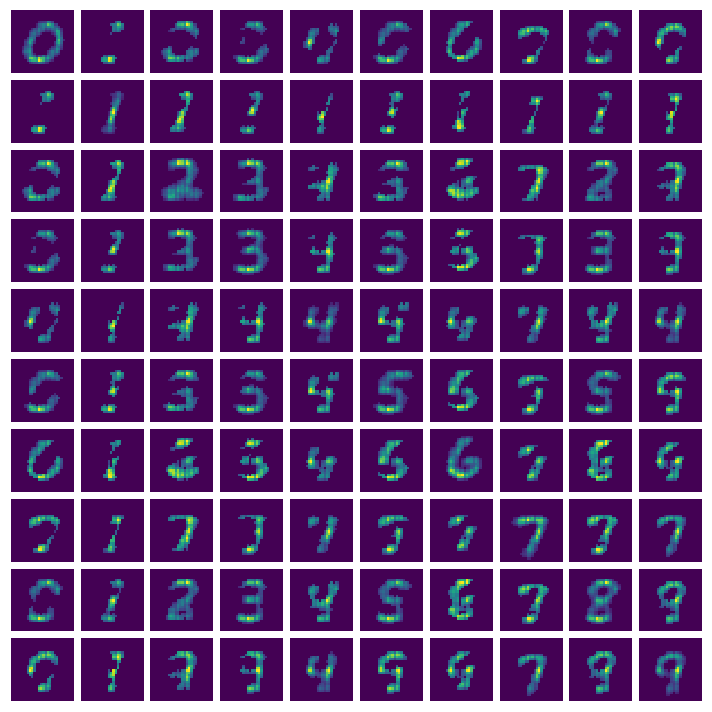

In [17]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        image = representatives[i] * representatives[j]
        print("{:4.1f}".format(np.sum(image)), end=", ")
        axes[i][j].imshow(image)
    print()
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This grid shows the squared error between any two digits, another way to heuristically determine similarity between images.

 0.0, 64.8, 52.8, 48.9, 54.0, 32.7, 44.2, 62.5, 43.4, 51.9, 
64.8,  0.0, 52.3, 41.9, 47.6, 49.0, 60.8, 49.8, 45.5, 46.1, 
52.8, 52.3,  0.0, 36.1, 54.6, 49.7, 43.5, 58.7, 35.1, 49.2, 
48.9, 41.9, 36.1,  0.0, 52.6, 20.6, 56.7, 55.8, 26.0, 44.7, 
54.0, 47.6, 54.6, 52.6,  0.0, 41.0, 44.9, 30.1, 41.1, 11.8, 
32.7, 49.0, 49.7, 20.6, 41.0,  0.0, 46.0, 47.5, 18.1, 33.5, 
44.2, 60.8, 43.5, 56.7, 44.9, 46.0,  0.0, 60.4, 50.7, 44.3, 
62.5, 49.8, 58.7, 55.8, 30.1, 47.5, 60.4,  0.0, 44.8, 19.8, 
43.4, 45.5, 35.1, 26.0, 41.1, 18.1, 50.7, 44.8,  0.0, 33.4, 
51.9, 46.1, 49.2, 44.7, 11.8, 33.5, 44.3, 19.8, 33.4,  0.0, 


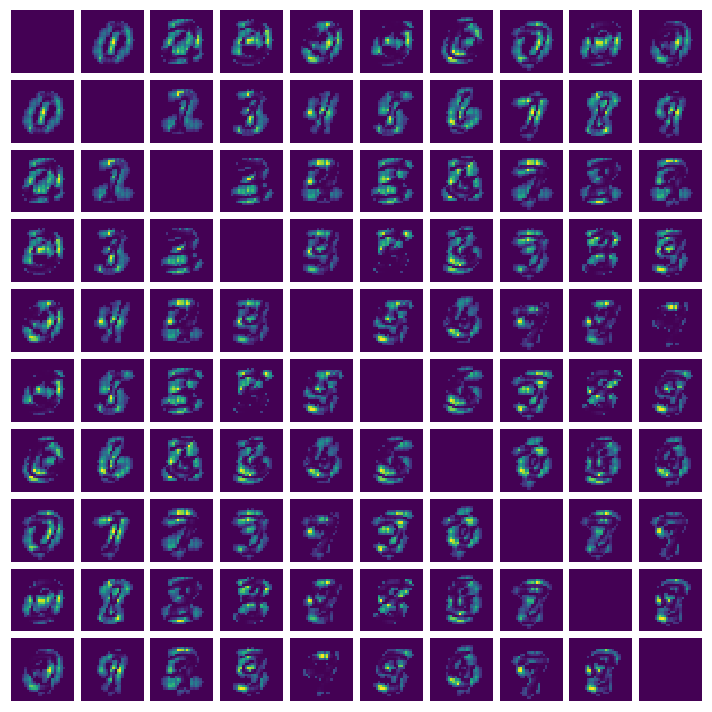

In [18]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        image = np.square(representatives[i] - representatives[j])
        print("{:4.1f}".format(np.sum(image)), end=", ")
        axes[i][j].imshow(image)
    print()
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The index of all incorrectly classified images is determined.

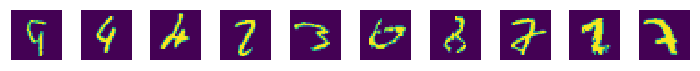

In [19]:
test_labels = np.argmax(test_y, axis=1)
predictions = np.argmax(conv2_model.predict(test_x), axis=1)
incorrect_indexes = np.nonzero(predictions != test_labels)[0]

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    image = test_x[incorrect_indexes[i]]
    axes[i].imshow(image)
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This function compared the investigates the incorrectly labeled images looks at the similarities between the image and the digit representatives using multiplication (bottom row) and squared error (top row) heuristic methods.

This examples is not explained well using these methods, but that is to be expected.

Label: 9
Predictions: 5
    MSE    Overlap
0:  72.2,  16.6
1:  51.0,   7.4
2:  60.7,  24.6
3:  54.7,  20.6
4:  35.3,  22.3
5:  51.8,  23.8
6:  58.3,  23.3
7:  52.2,  19.3
8:  49.1,  28.1
9:  32.7,  26.9


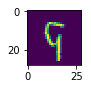

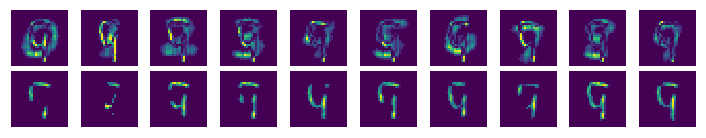

In [20]:
def compare_image(idx):
    print("Label: {}".format(test_labels[idx]))
    print("Predictions: {}".format(predictions[idx]))
    print("    MSE    Overlap")

    plt.figure(figsize=(1,1))
    plt.imshow(test_x[idx])

    fig, axes = plt.subplots(2, 10, figsize=(10,2))
    for i in range(10):
        print(i, end=": ")
        
        image = test_x[idx]

        difference = np.square(image - representatives[i])
        overlap = image * representatives[i]

        print("{:5.1f}".format(np.sum(difference)), end=", ")
        axes[0][i].imshow(difference)

        print("{:5.1f}".format(np.sum(overlap)))
        axes[1][i].imshow(overlap)

    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
 

compare_image(incorrect_indexes[0])

In this example, the 4 is misclassified as a 9. This can be explained as the image has the biggest overlap with the representative of 9, rather than 4. Additionally the sum squared error is lower for 4 than 9. Some of the next few examples display the same characteristics, while some do not (like the first example).

Label: 4
Predictions: 9
    MSE    Overlap
0:  80.8,  20.2
1:  53.1,  14.3
2:  65.2,  30.2
3:  69.9,  20.9
4:  35.0,  30.3
5:  61.3,  26.9
6:  49.8,  35.4
7:  48.7,  29.0
8:  54.4,  33.3
9:  33.2,  34.6


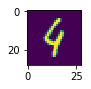

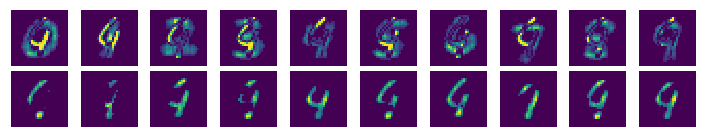

In [21]:
compare_image(incorrect_indexes[1])

Label: 4
Predictions: 2
    MSE    Overlap
0: 101.0,  20.3
1:  67.8,  17.2
2:  68.0,  39.1
3:  77.1,  27.5
4:  62.0,  27.1
5:  80.4,  27.6
6:  65.7,  37.7
7:  76.9,  25.1
8:  78.6,  31.5
9:  63.7,  29.6


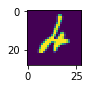

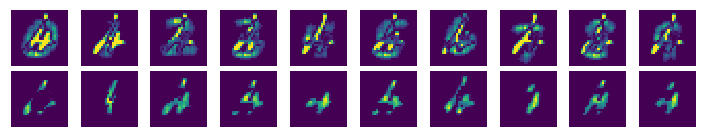

In [22]:
compare_image(incorrect_indexes[2])

Label: 2
Predictions: 7
    MSE    Overlap
0:  81.8,  22.9
1:  40.4,  23.9
2:  58.2,  37.0
3:  54.7,  31.8
4:  63.6,  19.3
5:  62.7,  29.5
6:  80.5,  23.3
7:  52.4,  30.4
8:  45.3,  41.2
9:  51.1,  28.9


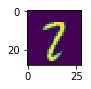

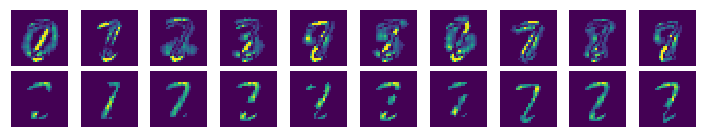

In [23]:
compare_image(incorrect_indexes[3])

Label: 3
Predictions: 7
    MSE    Overlap
0:  77.6,  23.0
1:  64.5,   9.8
2:  72.1,  28.0
3:  60.8,  26.7
4:  59.2,  19.5
5:  70.3,  23.7
6:  66.5,  28.4
7:  51.0,  29.1
8:  76.7,  23.5
9:  57.2,  23.9


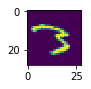

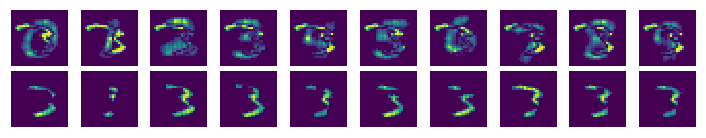

In [24]:
compare_image(incorrect_indexes[4])

There is a lot of overlap between these representatives, meaning showing only what pixels should be positive doesn't give us the full picture. The code below uses a technique similar to guided backprop to find what pixels need to not have data for an image to be classified correctly. Positive values are shown in red, and negative values are shown in blue.

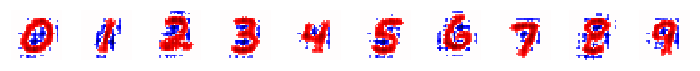

In [25]:
import tensorflow as tf


def guided_backprop(model, input_image, neuron_index=0):
    grad = tf.gradients(
        ys=model.layers[-2].output[:,neuron_index],
        xs=model.layers[-2].input,
        grad_ys=model.layers[-2].output[:,neuron_index],
        stop_gradients=model.layers[-2].input)
    
    for layer in model.layers[-3:0:-1]:            
        grad = tf.gradients(
            ys=layer.output,
            xs=layer.input,
            grad_ys=grad[0],
            stop_gradients=layer.input)
        
        if getattr(layer, 'activation', None) == keras.activations.get("relu"):
            pass
            #grad = [tf.maximum(grad[0], 0.)]
        
    sess = K.get_session()
    grad_val = sess.run(
        grad, 
        feed_dict={model.input: input_image})
            
    return grad_val[0]


heatmaps = np.empty((10,28,28))

fig, axes = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    images = train_x[labels == i]
    analysis = guided_backprop(conv2_model, images, i).squeeze()
    
    # rectify guided backprop results and get mean image
    analysis = np.maximum(-analysis, 0.)
    analysis = np.mean(analysis, axis=0)
    
    # normalize between 0 and 1
    analysis -= np.min(analysis) 
    analysis /= np.max(analysis)
    
    # remove any values below abritrary threshold
    # improves the likelihood that image is classified correctly
    analysis *= (analysis > 0.3)

    axes[i].imshow(representatives[i] - analysis, cmap="seismic")
    heatmaps[i] = representatives[i] - analysis
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

This function shows what makes similar comparisons, only now it uses the updated representatives.

Label: 9
Predictions: 5
    MSE    Overlap
0: 107.3,   7.7
1:  88.5,  -1.4
2:  84.7,  19.0
3:  83.3,  13.8
4:  42.3,  22.0
5:  77.4,  17.1
6:  87.2,  15.8
7:  67.4,  16.7
8:  76.4,  23.4
9:  47.3,  25.3


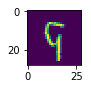

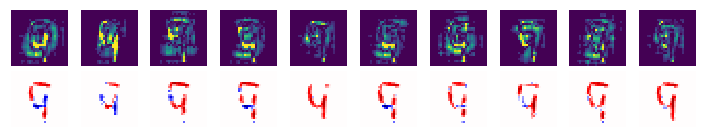

In [26]:
def compare_image_v2(idx):
    print("Label: {}".format(test_labels[idx]))
    print("Predictions: {}".format(predictions[idx]))
    print("    MSE    Overlap")

    plt.figure(figsize=(1,1))
    plt.imshow(test_x[idx])

    fig, axes = plt.subplots(2, 10, figsize=(10,2))
    for i in range(10):
        print(i, end=": ")
        
        image = test_x[idx]

        difference = np.square(image - heatmaps[i])
        overlap = image * heatmaps[i]

        print("{:5.1f}".format(np.sum(difference)), end=", ")
        axes[0][i].imshow(difference, vmin=0., vmax=1.)

        print("{:5.1f}".format(np.sum(overlap)))
        axes[1][i].imshow(overlap, cmap="seismic", vmin=-1., vmax=1.)

    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
 

compare_image_v2(incorrect_indexes[0])

Label: 4
Predictions: 9
    MSE    Overlap
0: 123.6,   7.5
1:  97.7,   1.9
2:  95.5,  21.6
3: 104.3,  11.1
4:  44.4,  28.9
5:  92.6,  17.4
6:  78.2,  28.2
7:  66.4,  25.1
8:  91.4,  23.8
9:  48.9,  32.4


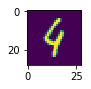

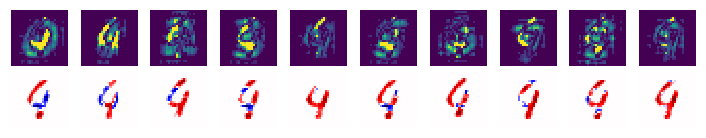

In [27]:
compare_image_v2(incorrect_indexes[1])

Label: 4
Predictions: 2
    MSE    Overlap
0: 150.4,   4.3
1: 117.6,   2.2
2: 105.8,  26.6
3: 112.0,  17.6
4:  81.5,  20.5
5: 117.7,  15.0
6: 110.2,  22.5
7: 102.5,  17.3
8: 124.5,  17.4
9:  93.4,  20.4


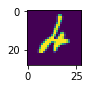

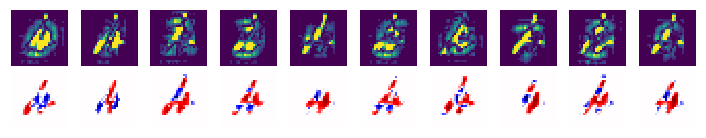

In [28]:
compare_image_v2(incorrect_indexes[2])

This sample can now be explained, where as before it was misclassified despite having the more overlap with the representative for the digit 7 rather than 2. Now we can see it has more positive overlap with the representative for 2 as opposed to 7. This can be used to explain why its misclassified. 

Label: 2
Predictions: 7
    MSE    Overlap
0: 123.9,  10.6
1:  67.3,  20.3
2:  81.7,  31.7
3:  83.5,  24.8
4:  72.7,  18.0
5:  95.6,  19.1
6: 116.3,  12.5
7:  67.3,  27.9
8:  78.9,  33.3
9:  70.4,  25.0


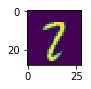

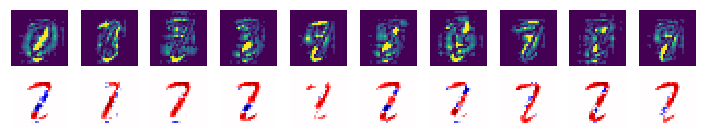

In [29]:
compare_image_v2(incorrect_indexes[3])

Label: 3
Predictions: 7
    MSE    Overlap
0: 108.2,  16.5
1: 100.1,   1.9
2: 102.9,  19.1
3:  81.4,  23.8
4:  73.6,  15.6
5:  92.3,  18.8
6:  94.6,  21.3
7:  65.9,  26.6
8: 113.0,  14.2
9:  76.5,  19.9


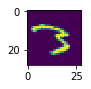

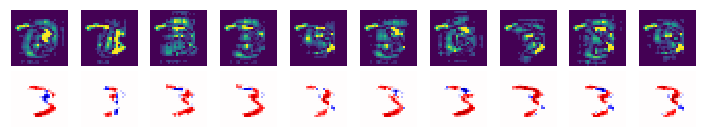

In [30]:
compare_image_v2(incorrect_indexes[4])